In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
from sklearn.metrics import mean_squared_error
import time
from energy_model import *
import glob
from eia_codes import eia_codes 

In [2]:
temp_df = pd.read_csv('nrel_psm_data/BrownsFerry_Temperature_2007_2020.csv')
temp_df.rename(columns={'time':'date'},inplace=True)
temp_df.index = pd.to_datetime(temp_df.date)
temp_df.drop(columns='date',inplace=True)
temp_df.head(2)

,Temp_BrownsFerry
date,
2007-01-01 00:00:00,6.0
2007-01-01 00:30:00,5.0


In [3]:
temp_monthly = temp_df.resample('M').mean()
temp_monthly.head(2)

,Temp_BrownsFerry
date,
2007-01-31,4.870968
2007-02-28,3.597470


In [4]:
plant_df = pd.read_csv('cooling_data/brownsferry_cooling.csv', index_col='date', parse_dates=True)
plant_df=plant_df.resample('M').mean()
plant_df.head(2)

,Plant ID,diversion_rate_kgM,withdrawal_rate_kgM,discharge_rate_kgM,consumption_rate_kgM,avg_intake_temp_C,max_intake_temp_C,avg_discharge_temp_C,max_discharge_temp_C,Nameplate Capacity (MW),max_withdrawal_rate_kgM
date,,,,,,,,,,,
2016-01-31,46.0,0.0,3.548266e+11,3.547620e+11,64620864.0,10.000000,15.000000,15.000000,59.0,3494.0,3.323013e+11
2016-02-29,46.0,0.0,3.326072e+11,3.318741e+11,733115174.4,9.444444,10.555556,11.666667,55.0,3494.0,3.108625e+11


In [5]:
combined = plant_df.merge(temp_monthly, on='date')

In [6]:
model = linear_fit(combined[['Temp_BrownsFerry', 'avg_intake_temp_C']])
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_intake_temp_C   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     708.3
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           3.37e-34
Time:                        10:02:07   Log-Likelihood:                -129.79
No. Observations:                  60   AIC:                             263.6
Df Residuals:                      58   BIC:                             267.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.4871      0.637  

In [7]:
y_pred_uni = model.fittedvalues

In [8]:
m = model.params[1]
b = model.params[0]

In [9]:
line = lambda t: m*t + b

In [10]:
model.pvalues

const               5.669531e-12
Temp_BrownsFerry    3.365825e-34
dtype: float64

In [11]:
model.t_test(np.eye(2))

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             5.4871      0.637      8.619      0.000       4.213       6.761
c1             0.9250      0.035     26.613      0.000       0.855       0.995

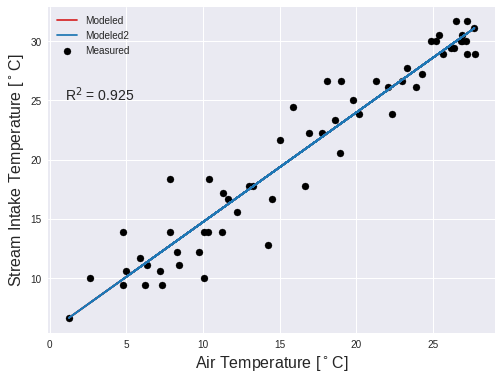

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(combined.Temp_BrownsFerry, combined.avg_intake_temp_C, label='Measured', marker='o', color='k')
ax.plot(combined.Temp_BrownsFerry, y_pred_uni, label='Modeled', color='tab:red')
ax.plot(combined.Temp_BrownsFerry, line(combined.Temp_BrownsFerry), label='Modeled2', color='tab:blue')
ax.text(x=1,y=25,s=r'R$^2$ = 0.925', fontsize=14)
ax.legend()
ax.set_xlabel('Air Temperature [$^\circ$C]', fontsize=16)
ax.set_ylabel('Stream Intake Temperature [$^\circ$C]', fontsize=16)
plt.show()

In [13]:
files = glob.glob('energy_balance/**.csv')

NineMilePointNuclearStation


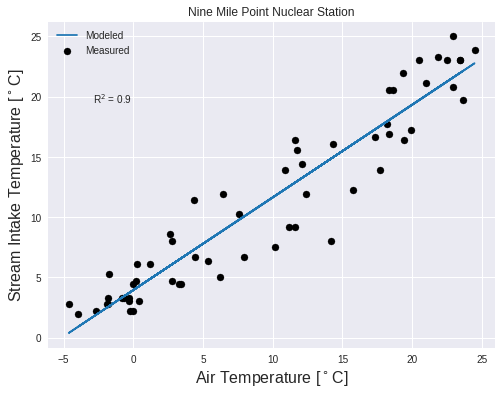

Oconee


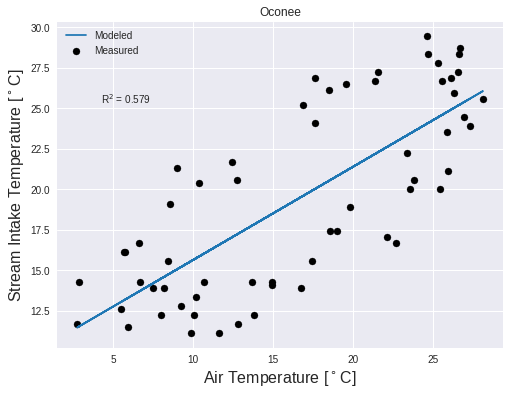

DonaldCCook


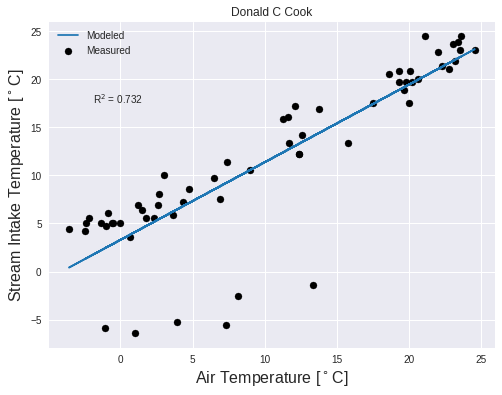

PointBeachNuclearPlant


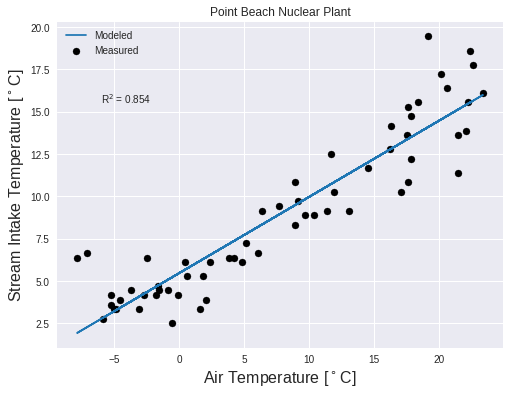

BrownsFerry


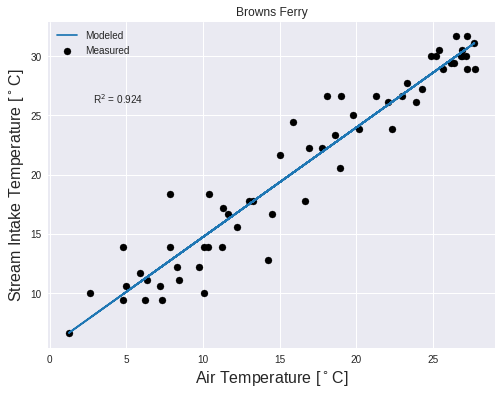

CooperNuclearStation


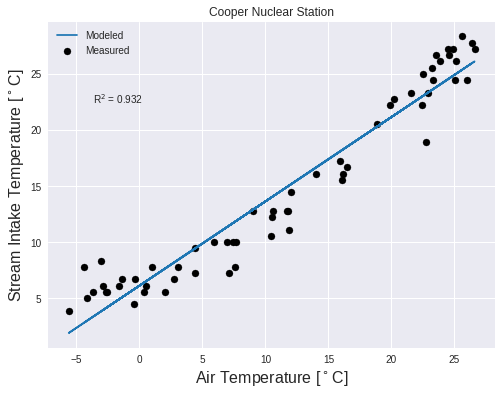

Surry


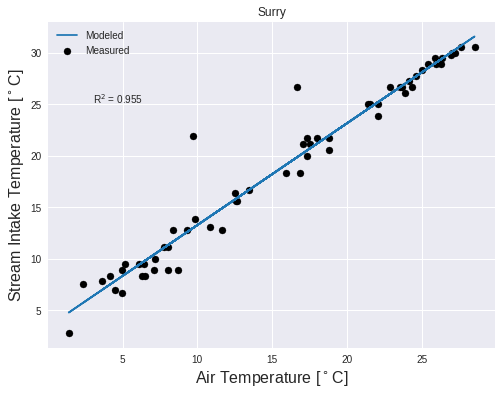

StLucie


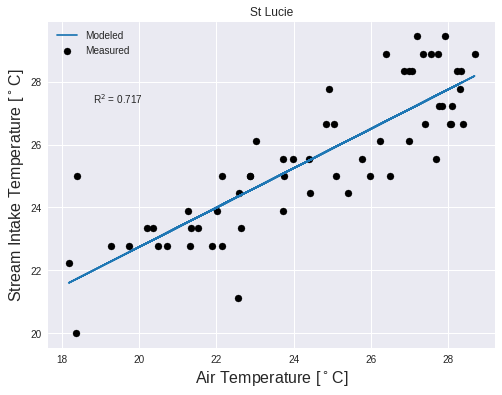

QuadCitiesGeneratingStation


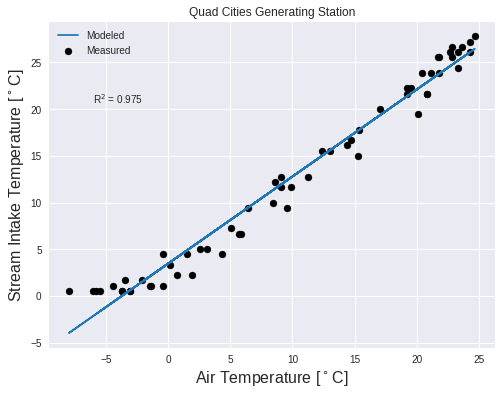

DiabloCanyon


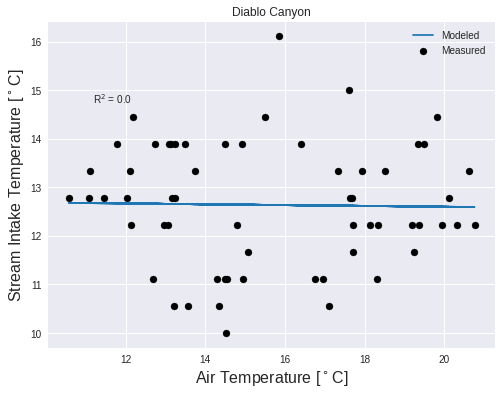

JamesAFitzpatrick


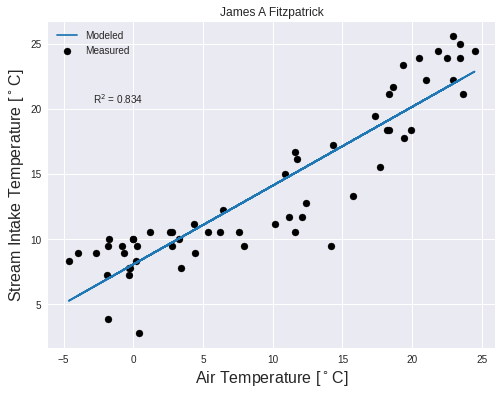

Seabrook


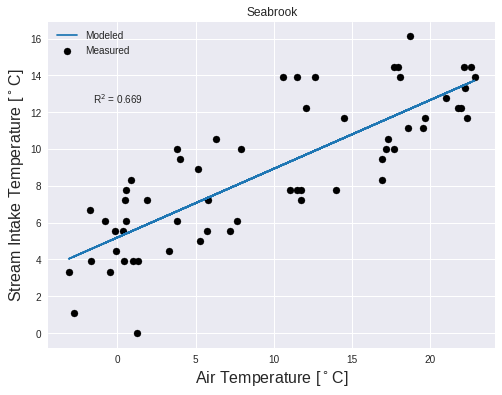

McGuire


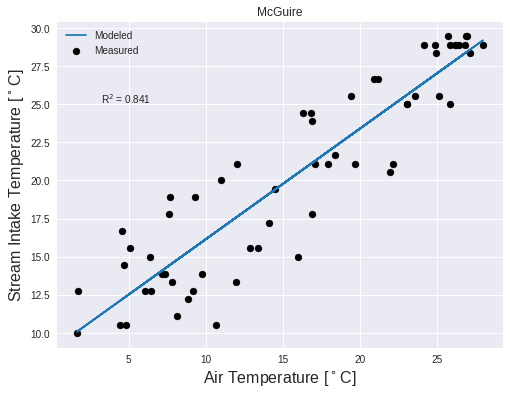

Millstone


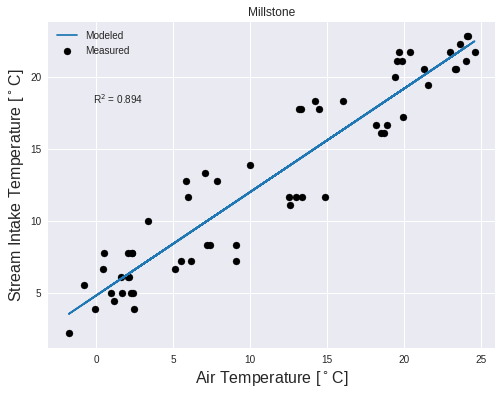

BrunswickNuclear


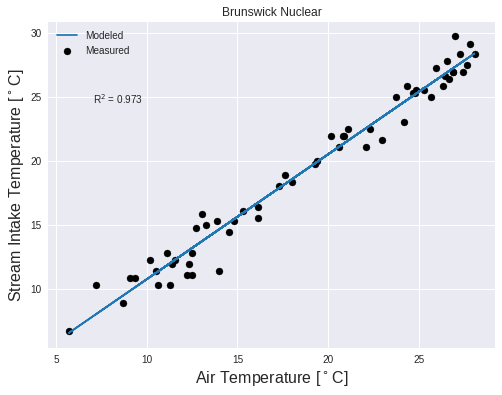

CalvertCliffsNuclearPowerPlant


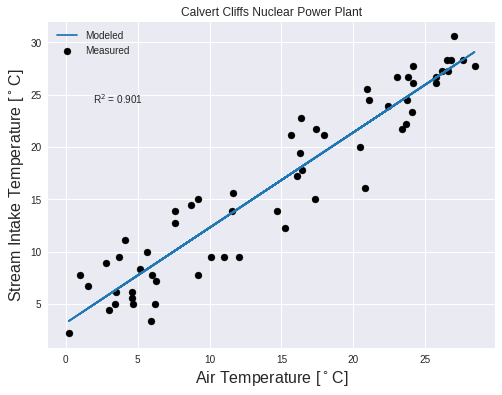

NorthAnna


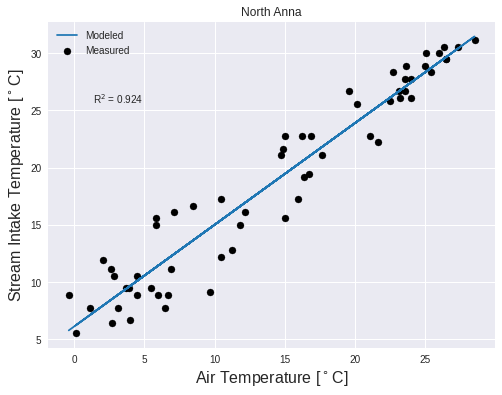

In [14]:
plant_codes = np.zeros(len(files))
plant_names = []
slopes = np.zeros(len(files))
intercepts = np.zeros(len(files))
rs_list = np.zeros(len(files))
for i,f in enumerate(files):
    # get the plant code
    code = int(f.strip('.csv').split('_')[-1])
    plant_name = eia_codes[code].replace(' ', '')
    print(plant_name)
    
    # get the plant data
    plant_df = pd.read_csv(f, index_col='date', parse_dates=True)
    plant_df = plant_df.resample('M').mean()  # only changes the dates to the last day of the month.
    
    # get the temperature data
    temp_file = f'nrel_psm_data/{plant_name}_Temperature_2007_2020.csv'
    temp_df = pd.read_csv(temp_file)
    temp_df.rename(columns={'time':'date', f'Temp_{plant_name}':'air_tempC'},inplace=True)
    temp_df.index = pd.to_datetime(temp_df.date)
    temp_df.drop(columns='date',inplace=True)
    
    # resample by month
    temp_monthly = temp_df.resample('M').mean()
    
    # combine
    combined = plant_df.merge(temp_monthly, on='date')
    
    # linear fit
    model = linear_fit(combined[['air_tempC', 'avg_intake_temp_C']])
    
    # get parameters
    m = model.params[1]
    b = model.params[0]
    rs = model.rsquared
    
    plant_codes[i] = code
    plant_names.append(eia_codes[code])
    slopes[i] = m
    intercepts[i] = b   
    rs_list[i] = rs
    
    y_pred_uni = model.fittedvalues
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(combined.air_tempC, combined.avg_intake_temp_C, label='Measured', marker='o', color='k')
    ax.plot(combined.air_tempC, y_pred_uni, label='Modeled', color='tab:blue')
#     ax.text(x=1,y=25,s=r'R$^2$ = {}'.format(rs), fontsize=14)
    ax.annotate(r'R$^2$ = {}'.format(round(rs,3)), xy=(.1, .75), xycoords=ax.transAxes)
    ax.legend()
    ax.set_xlabel('Air Temperature [$^\circ$C]', fontsize=16)
    ax.set_ylabel('Stream Intake Temperature [$^\circ$C]', fontsize=16)
    ax.set_title(f'{eia_codes[code]}')
    plt.show()

In [15]:
results = pd.DataFrame({'Plant ID':plant_codes,
                        'Plant Name':plant_names,
              'm':slopes,
              'b':intercepts,
              'rsquared':rs_list})
results

,Plant ID,Plant Name,m,b,rsquared
0,2589.0,Nine Mile Point Nuclear Station,0.768479,3.962971,0.900353
1,3265.0,Oconee,0.577095,9.851814,0.578522
2,6000.0,Donald C Cook,0.807460,3.294953,0.732331
3,4046.0,Point Beach Nuclear Plant,0.450419,5.471515,0.854042
4,46.0,Browns Ferry,0.924972,5.487117,0.924309
5,8036.0,Cooper Nuclear Station,0.752116,6.104858,0.932266
6,3806.0,Surry,0.988158,3.373812,0.955352
7,6045.0,St Lucie,0.627361,10.190062,0.716869
8,880.0,Quad Cities Generating Station,0.930590,3.481010,0.974580
9,6099.0,Diablo Canyon,-0.008413,12.770105,0.000369


In [16]:
results.describe()

,Plant ID,m,b,rsquared
count,17.000000,17.000000,17.000000,17.000000
mean,4578.470588,0.706762,5.954253,0.800288
std,2355.837460,0.257690,3.075313,0.235181
min,46.000000,-0.008413,0.979670,0.000369
25%,3265.000000,0.604790,3.481010,0.732331
50%,6011.000000,0.752116,5.471515,0.894263
75%,6099.000000,0.910969,8.053849,0.924309
max,8036.000000,0.988158,12.770105,0.974580


In [17]:
results.to_csv('linear_models/stream_model.csv')